# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [8]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

# Imports

In [9]:
import os
import copy
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import FocalLoss, TverskyLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [12]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-12-a11c6594a13c>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.2744, 0.2398, 0.1150,  ..., 0.2331, 0.2594, 0.2702],
         [0.2935, 0.2439, 0.1392,  ..., 0.2491, 0.2754, 0.2733],
         [0.3043, 0.1919, 0.1294,  ..., 0.2476, 0.2558, 0.2393],
         ...,
         [0.2635, 0.2481, 0.2017,  ..., 0.0346, 0.0253, 0.0583],
         [0.2109, 0.2001, 0.1862,  ..., 0.0304, 0.0315, 0.0557],
         [0.2249, 0.1913, 0.1511,  ..., 0.0521, 0.0593, 0.0789]],

        [[0.3315, 0.3102, 0.1517,  ..., 0.3761, 0.3999, 0.4025],
         [0.3434, 0.3170, 0.1815,  ..., 0.3880, 0.4101, 0.4059],
         [0.3527, 0.2473, 0.1670,  ..., 0.3795, 0.3855, 0.3544],
         ...,
         [0.3179, 0.3022, 0.2529,  ..., 0.0782, 0.0722, 0.1003],
         [0.2490, 0.2461, 0.2393,  ..., 0.0722, 0.0722, 0.0990],
         [0.2771, 0.2520, 0.2014,  ..., 0.0931, 0.1058, 0.1232]],

        [[0.3713, 0.3649, 0.1416,  ..., 0.3952, 0.4201, 0.4273],
         [0.3709, 0.3694, 0.1938,  ..., 0.4141, 0.4470, 0.4288],
         [0.3974, 0.2831, 0.1885,  ..., 0.4020, 0.4092, 0.

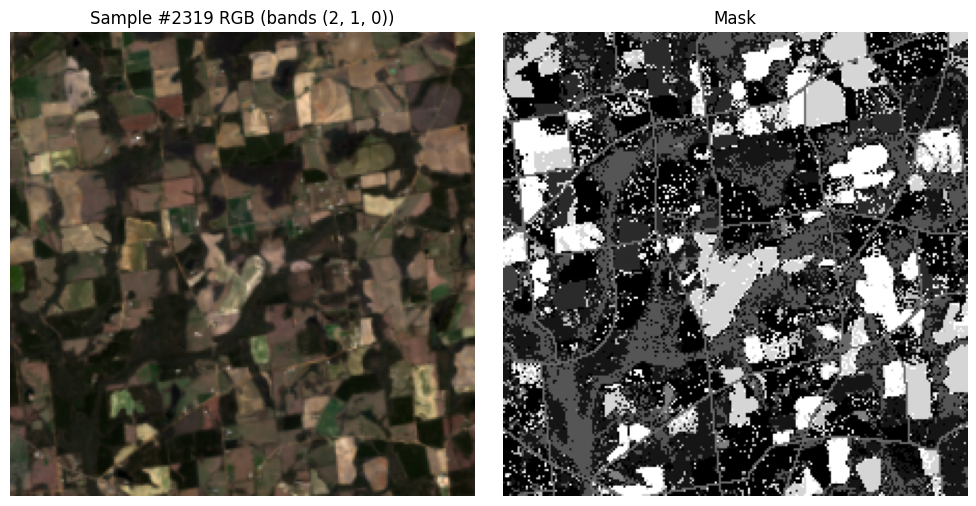

tensor([[[0.0799, 0.0787, 0.0775,  ..., 0.0720, 0.0796, 0.0926],
         [0.0773, 0.0775, 0.0741,  ..., 0.0729, 0.0588, 0.0836],
         [0.0803, 0.0801, 0.0764,  ..., 0.0764, 0.0824, 0.1361],
         ...,
         [0.0671, 0.0861, 0.0938,  ..., 0.0940, 0.1296, 0.1433],
         [0.0891, 0.0812, 0.0766,  ..., 0.0938, 0.1398, 0.1558],
         [0.1227, 0.0919, 0.0741,  ..., 0.0803, 0.1185, 0.1380]],

        [[0.1303, 0.1299, 0.1297,  ..., 0.0990, 0.1101, 0.1240],
         [0.1315, 0.1296, 0.1248,  ..., 0.1021, 0.0887, 0.1158],
         [0.1341, 0.1332, 0.1273,  ..., 0.1078, 0.1172, 0.1727],
         ...,
         [0.1038, 0.1248, 0.1370,  ..., 0.1183, 0.1639, 0.1836],
         [0.1259, 0.1158, 0.1160,  ..., 0.1250, 0.1834, 0.2051],
         [0.1654, 0.1303, 0.1128,  ..., 0.1120, 0.1576, 0.1826]],

        [[0.1362, 0.1333, 0.1323,  ..., 0.1177, 0.1343, 0.1473],
         [0.1353, 0.1302, 0.1237,  ..., 0.1140, 0.1049, 0.1338],
         [0.1374, 0.1343, 0.1270,  ..., 0.1155, 0.1358, 0.

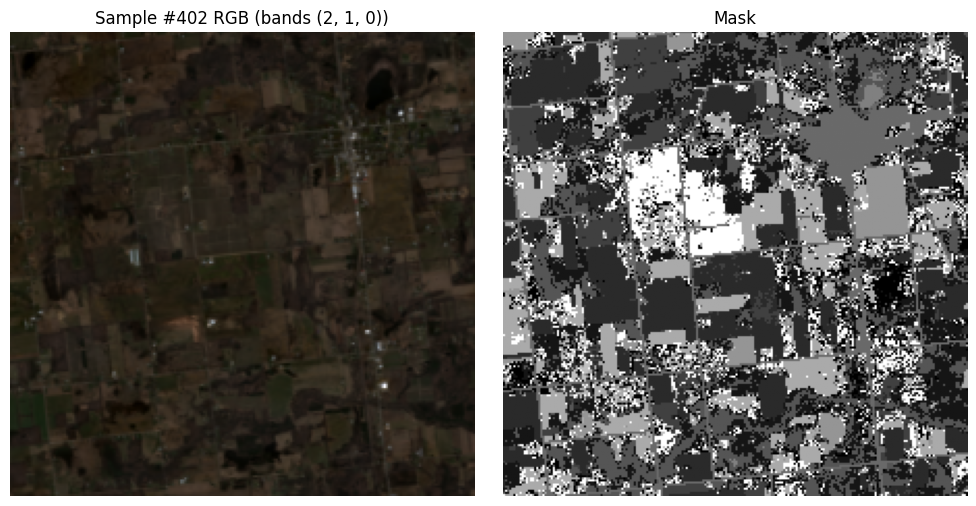

In [13]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [14]:
model = UnetPlusPlus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
tversky_loss =  TverskyLoss(
    mode='multiclass',
    classes=None,
    log_loss=False,
    from_logits=True,
    ignore_index=0,
    gamma=1.0
)

ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    L_trev = tversky_loss(preds, targets)

    return 1 * L_trev


scheduler = scheduler = PolynomialLR(
    optimizer,
    total_iters=EPOCHS,
    power=2.0,
    last_epoch=-1,
    verbose=True
)

In [15]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-12-a11c6594a13c>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 78/78 [18:57<00:00, 14.58s/it]


[Epoch  0] Loss:  0.7823, Acc:   0.1629, IoU:   0.0926, Dice:  0.0796, mIoU:  0.0546


Epoch 1/50 [Val]: 100%|██████████| 20/20 [03:14<00:00,  9.74s/it]


[Epoch  0] Loss: 0.7347, Acc: 0.2151, IoU: 0.1245, Dice: 0.1018, mIoU: 0.0710


Epoch 2/50: 100%|██████████| 78/78 [10:54<00:00,  8.39s/it]


[Epoch  1] Loss:  0.6765, Acc:   0.2649, IoU:   0.1640, Dice:  0.1283, mIoU:  0.0913


Epoch 2/50 [Val]: 100%|██████████| 20/20 [02:17<00:00,  6.87s/it]


[Epoch  1] Loss: 0.6695, Acc: 0.2890, IoU: 0.1719, Dice: 0.1332, mIoU: 0.0956


Epoch 3/50: 100%|██████████| 78/78 [10:34<00:00,  8.14s/it]


[Epoch  2] Loss:  0.6335, Acc:   0.3056, IoU:   0.1940, Dice:  0.1476, mIoU:  0.1078


Epoch 3/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.56s/it]


[Epoch  2] Loss: 0.6425, Acc: 0.3086, IoU: 0.1911, Dice: 0.1430, mIoU: 0.1047


Epoch 4/50: 100%|██████████| 78/78 [10:22<00:00,  7.98s/it]


[Epoch  3] Loss:  0.6043, Acc:   0.3319, IoU:   0.2151, Dice:  0.1635, mIoU:  0.1215


Epoch 4/50 [Val]: 100%|██████████| 20/20 [02:14<00:00,  6.75s/it]


[Epoch  3] Loss: 0.6187, Acc: 0.3231, IoU: 0.2075, Dice: 0.1594, mIoU: 0.1185


Epoch 5/50: 100%|██████████| 78/78 [09:39<00:00,  7.43s/it]


[Epoch  4] Loss:  0.5822, Acc:   0.3511, IoU:   0.2309, Dice:  0.1767, mIoU:  0.1328


Epoch 5/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.47s/it]


[Epoch  4] Loss: 0.6117, Acc: 0.3234, IoU: 0.2138, Dice: 0.1647, mIoU: 0.1235


Epoch 6/50: 100%|██████████| 78/78 [10:04<00:00,  7.75s/it]


[Epoch  5] Loss:  0.5662, Acc:   0.3639, IoU:   0.2434, Dice:  0.1859, mIoU:  0.1412


Epoch 6/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


[Epoch  5] Loss: 0.5927, Acc: 0.3345, IoU: 0.2296, Dice: 0.1744, mIoU: 0.1328


Epoch 7/50: 100%|██████████| 78/78 [09:16<00:00,  7.14s/it]


[Epoch  6] Loss:  0.5475, Acc:   0.3795, IoU:   0.2581, Dice:  0.1946, mIoU:  0.1491


Epoch 7/50 [Val]: 100%|██████████| 20/20 [02:12<00:00,  6.65s/it]


[Epoch  6] Loss: 0.5678, Acc: 0.3670, IoU: 0.2477, Dice: 0.1873, mIoU: 0.1431


Epoch 8/50: 100%|██████████| 78/78 [09:31<00:00,  7.32s/it]


[Epoch  7] Loss:  0.5346, Acc:   0.3918, IoU:   0.2680, Dice:  0.2004, mIoU:  0.1545


Epoch 8/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.58s/it]


[Epoch  7] Loss: 0.5533, Acc: 0.3781, IoU: 0.2578, Dice: 0.1901, mIoU: 0.1463


Epoch 9/50: 100%|██████████| 78/78 [10:08<00:00,  7.80s/it]


[Epoch  8] Loss:  0.5219, Acc:   0.4067, IoU:   0.2773, Dice:  0.2033, mIoU:  0.1575


Epoch 9/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


[Epoch  8] Loss: 0.5404, Acc: 0.3888, IoU: 0.2677, Dice: 0.1967, mIoU: 0.1534


Epoch 10/50: 100%|██████████| 78/78 [10:17<00:00,  7.91s/it]


[Epoch  9] Loss:  0.5128, Acc:   0.4154, IoU:   0.2843, Dice:  0.2064, mIoU:  0.1608


Epoch 10/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.52s/it]


[Epoch  9] Loss: 0.5512, Acc: 0.3745, IoU: 0.2602, Dice: 0.1928, mIoU: 0.1496


Epoch 11/50: 100%|██████████| 78/78 [09:52<00:00,  7.60s/it]


[Epoch 10] Loss:  0.5037, Acc:   0.4243, IoU:   0.2914, Dice:  0.2112, mIoU:  0.1652


Epoch 11/50 [Val]: 100%|██████████| 20/20 [02:35<00:00,  7.79s/it]


[Epoch 10] Loss: 0.5319, Acc: 0.4048, IoU: 0.2766, Dice: 0.2056, mIoU: 0.1615


Epoch 12/50: 100%|██████████| 78/78 [09:31<00:00,  7.33s/it]


[Epoch 11] Loss:  0.5011, Acc:   0.4284, IoU:   0.2941, Dice:  0.2132, mIoU:  0.1673


Epoch 12/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.26s/it]


[Epoch 11] Loss: 0.5298, Acc: 0.4117, IoU: 0.2771, Dice: 0.2072, mIoU: 0.1617


Epoch 13/50: 100%|██████████| 78/78 [10:04<00:00,  7.75s/it]


[Epoch 12] Loss:  0.4944, Acc:   0.4335, IoU:   0.2994, Dice:  0.2166, mIoU:  0.1705


Epoch 13/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.40s/it]


[Epoch 12] Loss: 0.5166, Acc: 0.4141, IoU: 0.2867, Dice: 0.2078, mIoU: 0.1641


Epoch 14/50: 100%|██████████| 78/78 [09:32<00:00,  7.33s/it]


[Epoch 13] Loss:  0.4868, Acc:   0.4398, IoU:   0.3058, Dice:  0.2207, mIoU:  0.1742


Epoch 14/50 [Val]: 100%|██████████| 20/20 [02:33<00:00,  7.67s/it]


[Epoch 13] Loss: 0.5168, Acc: 0.4148, IoU: 0.2881, Dice: 0.2124, mIoU: 0.1676


Epoch 15/50: 100%|██████████| 78/78 [10:04<00:00,  7.75s/it]


[Epoch 14] Loss:  0.4786, Acc:   0.4466, IoU:   0.3124, Dice:  0.2245, mIoU:  0.1782


Epoch 15/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


[Epoch 14] Loss: 0.5188, Acc: 0.4246, IoU: 0.2843, Dice: 0.2089, mIoU: 0.1640


Epoch 16/50: 100%|██████████| 78/78 [09:57<00:00,  7.66s/it]


[Epoch 15] Loss:  0.4719, Acc:   0.4535, IoU:   0.3184, Dice:  0.2282, mIoU:  0.1822


Epoch 16/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.38s/it]


[Epoch 15] Loss: 0.5119, Acc: 0.4312, IoU: 0.2925, Dice: 0.2206, mIoU: 0.1753


Epoch 17/50: 100%|██████████| 78/78 [09:39<00:00,  7.43s/it]


[Epoch 16] Loss:  0.4689, Acc:   0.4553, IoU:   0.3206, Dice:  0.2294, mIoU:  0.1843


Epoch 17/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


[Epoch 16] Loss: 0.5113, Acc: 0.4334, IoU: 0.2922, Dice: 0.2207, mIoU: 0.1756


Epoch 18/50: 100%|██████████| 78/78 [09:28<00:00,  7.28s/it]


[Epoch 17] Loss:  0.4636, Acc:   0.4606, IoU:   0.3250, Dice:  0.2336, mIoU:  0.1882


Epoch 18/50 [Val]: 100%|██████████| 20/20 [02:05<00:00,  6.27s/it]


[Epoch 17] Loss: 0.5032, Acc: 0.4382, IoU: 0.2997, Dice: 0.2270, mIoU: 0.1816


Epoch 19/50: 100%|██████████| 78/78 [08:59<00:00,  6.92s/it]


[Epoch 18] Loss:  0.4580, Acc:   0.4662, IoU:   0.3300, Dice:  0.2362, mIoU:  0.1912


Epoch 19/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.24s/it]


[Epoch 18] Loss: 0.5115, Acc: 0.4218, IoU: 0.2941, Dice: 0.2249, mIoU: 0.1824


Epoch 20/50: 100%|██████████| 78/78 [09:58<00:00,  7.67s/it]


[Epoch 19] Loss:  0.4497, Acc:   0.4726, IoU:   0.3369, Dice:  0.2403, mIoU:  0.1962


Epoch 20/50 [Val]: 100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


[Epoch 19] Loss: 0.5091, Acc: 0.4242, IoU: 0.2966, Dice: 0.2263, mIoU: 0.1826


Epoch 21/50: 100%|██████████| 78/78 [10:21<00:00,  7.97s/it]


[Epoch 20] Loss:  0.4505, Acc:   0.4728, IoU:   0.3367, Dice:  0.2408, mIoU:  0.1962


Epoch 21/50 [Val]: 100%|██████████| 20/20 [02:14<00:00,  6.74s/it]


[Epoch 20] Loss: 0.4941, Acc: 0.4463, IoU: 0.3061, Dice: 0.2287, mIoU: 0.1829


Epoch 22/50: 100%|██████████| 78/78 [10:23<00:00,  8.00s/it]


[Epoch 21] Loss:  0.4469, Acc:   0.4770, IoU:   0.3401, Dice:  0.2437, mIoU:  0.1994


Epoch 22/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


[Epoch 21] Loss: 0.5056, Acc: 0.4228, IoU: 0.2995, Dice: 0.2315, mIoU: 0.1875


Epoch 23/50: 100%|██████████| 78/78 [09:36<00:00,  7.39s/it]


[Epoch 22] Loss:  0.4395, Acc:   0.4835, IoU:   0.3464, Dice:  0.2475, mIoU:  0.2032


Epoch 23/50 [Val]: 100%|██████████| 20/20 [02:14<00:00,  6.73s/it]


[Epoch 22] Loss: 0.4841, Acc: 0.4463, IoU: 0.3155, Dice: 0.2368, mIoU: 0.1932


Epoch 24/50: 100%|██████████| 78/78 [09:50<00:00,  7.57s/it]


[Epoch 23] Loss:  0.4351, Acc:   0.4872, IoU:   0.3501, Dice:  0.2495, mIoU:  0.2061


Epoch 24/50 [Val]: 100%|██████████| 20/20 [02:27<00:00,  7.36s/it]


[Epoch 23] Loss: 0.4847, Acc: 0.4438, IoU: 0.3154, Dice: 0.2389, mIoU: 0.1944


Epoch 25/50: 100%|██████████| 78/78 [10:03<00:00,  7.74s/it]


[Epoch 24] Loss:  0.4386, Acc:   0.4850, IoU:   0.3473, Dice:  0.2482, mIoU:  0.2046


Epoch 25/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.40s/it]


[Epoch 24] Loss: 0.5222, Acc: 0.4077, IoU: 0.2851, Dice: 0.2250, mIoU: 0.1818


Epoch 26/50: 100%|██████████| 78/78 [09:20<00:00,  7.19s/it]


[Epoch 25] Loss:  0.4337, Acc:   0.4889, IoU:   0.3510, Dice:  0.2512, mIoU:  0.2082


Epoch 26/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.35s/it]


[Epoch 25] Loss: 0.4745, Acc: 0.4499, IoU: 0.3236, Dice: 0.2407, mIoU: 0.1986


Epoch 27/50: 100%|██████████| 78/78 [09:33<00:00,  7.35s/it]


[Epoch 26] Loss:  0.4247, Acc:   0.4964, IoU:   0.3593, Dice:  0.2547, mIoU:  0.2123


Epoch 27/50 [Val]: 100%|██████████| 20/20 [02:26<00:00,  7.35s/it]


[Epoch 26] Loss: 0.4679, Acc: 0.4610, IoU: 0.3286, Dice: 0.2445, mIoU: 0.2014


Epoch 28/50: 100%|██████████| 78/78 [09:39<00:00,  7.43s/it]


[Epoch 27] Loss:  0.4195, Acc:   0.5013, IoU:   0.3640, Dice:  0.2578, mIoU:  0.2158


Epoch 28/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


[Epoch 27] Loss: 0.4698, Acc: 0.4626, IoU: 0.3278, Dice: 0.2444, mIoU: 0.2024


Epoch 29/50: 100%|██████████| 78/78 [09:59<00:00,  7.68s/it]


[Epoch 28] Loss:  0.4185, Acc:   0.5024, IoU:   0.3648, Dice:  0.2587, mIoU:  0.2166


Epoch 29/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.36s/it]


[Epoch 28] Loss: 0.4666, Acc: 0.4704, IoU: 0.3298, Dice: 0.2473, mIoU: 0.2045


Epoch 30/50: 100%|██████████| 78/78 [09:12<00:00,  7.09s/it]


[Epoch 29] Loss:  0.4154, Acc:   0.5052, IoU:   0.3679, Dice:  0.2603, mIoU:  0.2189


Epoch 30/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.34s/it]


[Epoch 29] Loss: 0.4716, Acc: 0.4657, IoU: 0.3260, Dice: 0.2472, mIoU: 0.2032


Epoch 31/50: 100%|██████████| 78/78 [09:57<00:00,  7.67s/it]


[Epoch 30] Loss:  0.4158, Acc:   0.5055, IoU:   0.3674, Dice:  0.2599, mIoU:  0.2185


Epoch 31/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.53s/it]


[Epoch 30] Loss: 0.4649, Acc: 0.4682, IoU: 0.3316, Dice: 0.2474, mIoU: 0.2060


Epoch 32/50: 100%|██████████| 78/78 [09:13<00:00,  7.10s/it]


[Epoch 31] Loss:  0.4123, Acc:   0.5085, IoU:   0.3710, Dice:  0.2622, mIoU:  0.2211


Epoch 32/50 [Val]: 100%|██████████| 20/20 [02:02<00:00,  6.12s/it]


[Epoch 31] Loss: 0.4645, Acc: 0.4735, IoU: 0.3322, Dice: 0.2492, mIoU: 0.2063


Epoch 33/50: 100%|██████████| 78/78 [09:36<00:00,  7.39s/it]


[Epoch 32] Loss:  0.4082, Acc:   0.5127, IoU:   0.3744, Dice:  0.2647, mIoU:  0.2234


Epoch 33/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.23s/it]


[Epoch 32] Loss: 0.4686, Acc: 0.4721, IoU: 0.3294, Dice: 0.2482, mIoU: 0.2054


Epoch 34/50: 100%|██████████| 78/78 [09:43<00:00,  7.48s/it]


[Epoch 33] Loss:  0.4070, Acc:   0.5140, IoU:   0.3756, Dice:  0.2662, mIoU:  0.2255


Epoch 34/50 [Val]: 100%|██████████| 20/20 [02:09<00:00,  6.45s/it]


[Epoch 33] Loss: 0.4751, Acc: 0.4584, IoU: 0.3244, Dice: 0.2475, mIoU: 0.2039


Epoch 35/50: 100%|██████████| 78/78 [09:47<00:00,  7.54s/it]


[Epoch 34] Loss:  0.4030, Acc:   0.5174, IoU:   0.3796, Dice:  0.2676, mIoU:  0.2271


Epoch 35/50 [Val]: 100%|██████████| 20/20 [02:30<00:00,  7.52s/it]


[Epoch 34] Loss: 0.4710, Acc: 0.4559, IoU: 0.3281, Dice: 0.2513, mIoU: 0.2098


Epoch 36/50: 100%|██████████| 78/78 [09:34<00:00,  7.36s/it]


[Epoch 35] Loss:  0.3991, Acc:   0.5206, IoU:   0.3831, Dice:  0.2700, mIoU:  0.2299


Epoch 36/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.35s/it]


[Epoch 35] Loss: 0.4793, Acc: 0.4457, IoU: 0.3222, Dice: 0.2518, mIoU: 0.2092


Epoch 37/50: 100%|██████████| 78/78 [09:28<00:00,  7.29s/it]


[Epoch 36] Loss:  0.4009, Acc:   0.5198, IoU:   0.3817, Dice:  0.2702, mIoU:  0.2299


Epoch 37/50 [Val]: 100%|██████████| 20/20 [02:06<00:00,  6.31s/it]


[Epoch 36] Loss: 0.4807, Acc: 0.4437, IoU: 0.3191, Dice: 0.2497, mIoU: 0.2073


Epoch 38/50: 100%|██████████| 78/78 [09:27<00:00,  7.28s/it]


[Epoch 37] Loss:  0.3941, Acc:   0.5254, IoU:   0.3878, Dice:  0.2728, mIoU:  0.2322


Epoch 38/50 [Val]: 100%|██████████| 20/20 [02:20<00:00,  7.03s/it]


[Epoch 37] Loss: 0.4749, Acc: 0.4483, IoU: 0.3259, Dice: 0.2514, mIoU: 0.2094


Epoch 39/50: 100%|██████████| 78/78 [09:20<00:00,  7.19s/it]


[Epoch 38] Loss:  0.3932, Acc:   0.5263, IoU:   0.3886, Dice:  0.2735, mIoU:  0.2335


Epoch 39/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.25s/it]


[Epoch 38] Loss: 0.4756, Acc: 0.4415, IoU: 0.3247, Dice: 0.2522, mIoU: 0.2124


Epoch 40/50: 100%|██████████| 78/78 [09:00<00:00,  6.92s/it]


[Epoch 39] Loss:  0.3937, Acc:   0.5255, IoU:   0.3878, Dice:  0.2738, mIoU:  0.2344


Epoch 40/50 [Val]: 100%|██████████| 20/20 [01:55<00:00,  5.76s/it]


[Epoch 39] Loss: 0.4672, Acc: 0.4564, IoU: 0.3323, Dice: 0.2556, mIoU: 0.2138


Epoch 41/50: 100%|██████████| 78/78 [09:18<00:00,  7.16s/it]


[Epoch 40] Loss:  0.3903, Acc:   0.5291, IoU:   0.3913, Dice:  0.2756, mIoU:  0.2360


Epoch 41/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.56s/it]


[Epoch 40] Loss: 0.4561, Acc: 0.4735, IoU: 0.3408, Dice: 0.2572, mIoU: 0.2157


Epoch 42/50: 100%|██████████| 78/78 [10:02<00:00,  7.72s/it]


[Epoch 41] Loss:  0.3858, Acc:   0.5332, IoU:   0.3952, Dice:  0.2782, mIoU:  0.2388


Epoch 42/50 [Val]: 100%|██████████| 20/20 [02:10<00:00,  6.53s/it]


[Epoch 41] Loss: 0.4618, Acc: 0.4646, IoU: 0.3360, Dice: 0.2556, mIoU: 0.2140


Epoch 43/50: 100%|██████████| 78/78 [09:38<00:00,  7.42s/it]


[Epoch 42] Loss:  0.3906, Acc:   0.5291, IoU:   0.3910, Dice:  0.2767, mIoU:  0.2364


Epoch 43/50 [Val]: 100%|██████████| 20/20 [02:27<00:00,  7.36s/it]


[Epoch 42] Loss: 0.4603, Acc: 0.4692, IoU: 0.3379, Dice: 0.2590, mIoU: 0.2156


Epoch 44/50: 100%|██████████| 78/78 [09:34<00:00,  7.37s/it]


[Epoch 43] Loss:  0.3845, Acc:   0.5349, IoU:   0.3968, Dice:  0.2799, mIoU:  0.2409


Epoch 44/50 [Val]: 100%|██████████| 20/20 [02:11<00:00,  6.60s/it]


[Epoch 43] Loss: 0.4725, Acc: 0.4499, IoU: 0.3269, Dice: 0.2528, mIoU: 0.2134


Epoch 45/50: 100%|██████████| 78/78 [09:40<00:00,  7.44s/it]


[Epoch 44] Loss:  0.3812, Acc:   0.5376, IoU:   0.3997, Dice:  0.2812, mIoU:  0.2430


Epoch 45/50 [Val]: 100%|██████████| 20/20 [02:04<00:00,  6.23s/it]


[Epoch 44] Loss: 0.4591, Acc: 0.4647, IoU: 0.3386, Dice: 0.2578, mIoU: 0.2179


Epoch 46/50: 100%|██████████| 78/78 [09:58<00:00,  7.68s/it]


[Epoch 45] Loss:  0.3831, Acc:   0.5364, IoU:   0.3981, Dice:  0.2808, mIoU:  0.2420


Epoch 46/50 [Val]: 100%|██████████| 20/20 [01:46<00:00,  5.35s/it]


[Epoch 45] Loss: 0.4559, Acc: 0.4622, IoU: 0.3411, Dice: 0.2580, mIoU: 0.2190


Epoch 47/50: 100%|██████████| 78/78 [09:58<00:00,  7.67s/it]


[Epoch 46] Loss:  0.3780, Acc:   0.5408, IoU:   0.4031, Dice:  0.2838, mIoU:  0.2460


Epoch 47/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.42s/it]


[Epoch 46] Loss: 0.4574, Acc: 0.4642, IoU: 0.3407, Dice: 0.2587, mIoU: 0.2211


Epoch 48/50: 100%|██████████| 78/78 [09:26<00:00,  7.26s/it]


[Epoch 47] Loss:  0.3761, Acc:   0.5418, IoU:   0.4049, Dice:  0.2843, mIoU:  0.2462


Epoch 48/50 [Val]: 100%|██████████| 20/20 [02:08<00:00,  6.45s/it]


[Epoch 47] Loss: 0.4530, Acc: 0.4707, IoU: 0.3428, Dice: 0.2605, mIoU: 0.2213


Epoch 49/50: 100%|██████████| 78/78 [09:32<00:00,  7.33s/it]


[Epoch 48] Loss:  0.3758, Acc:   0.5428, IoU:   0.4051, Dice:  0.2853, mIoU:  0.2471


Epoch 49/50 [Val]: 100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


[Epoch 48] Loss: 0.4472, Acc: 0.4776, IoU: 0.3487, Dice: 0.2620, mIoU: 0.2227


Epoch 50/50: 100%|██████████| 78/78 [09:58<00:00,  7.68s/it]


[Epoch 49] Loss:  0.3706, Acc:   0.5467, IoU:   0.4100, Dice:  0.2879, mIoU:  0.2502


Epoch 50/50 [Val]: 100%|██████████| 20/20 [01:44<00:00,  5.24s/it]


[Epoch 49] Loss: 0.4514, Acc: 0.4726, IoU: 0.3435, Dice: 0.2623, mIoU: 0.2237


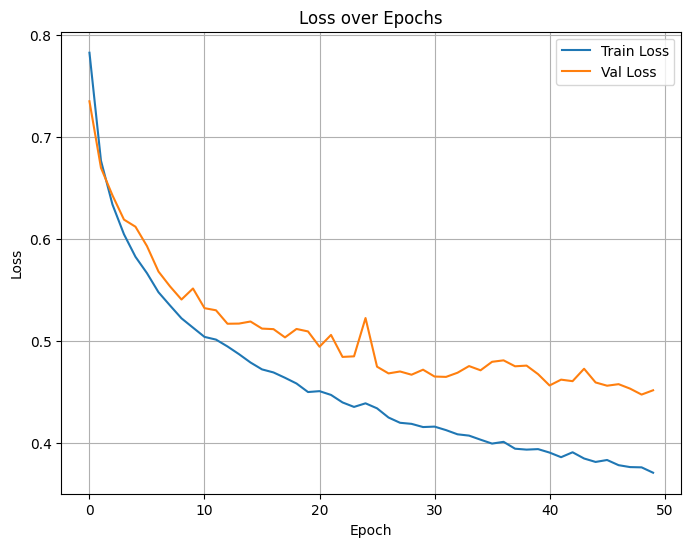

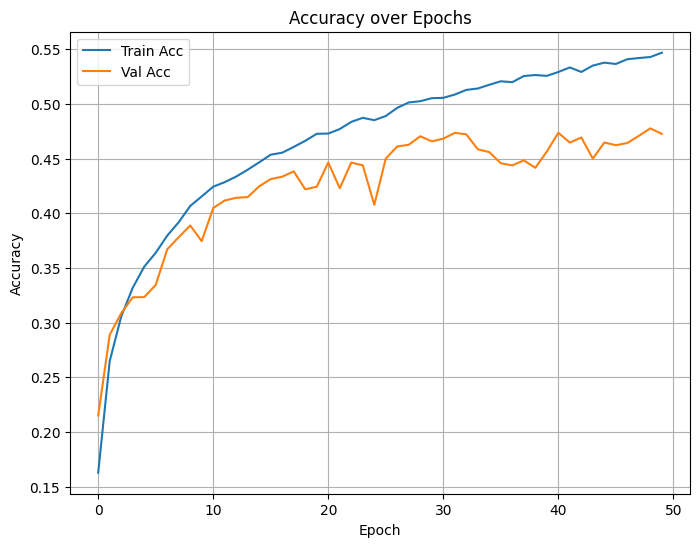

In [16]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []
best_val_acc = 0.0
best_epoch     = 0
best_model_wts = None

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_acc = accuracy.compute().item()
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(val_acc)
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_epoch     = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())


model.load_state_dict(best_model_wts)


# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_loss_20250516-204444_normalized_polynomial_trevesky.png


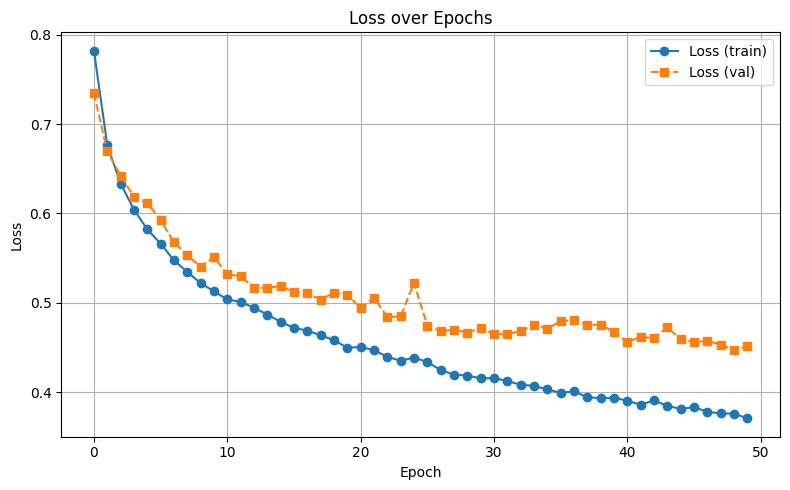

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_accuracy_20250516-204444_normalized_polynomial_trevesky.png


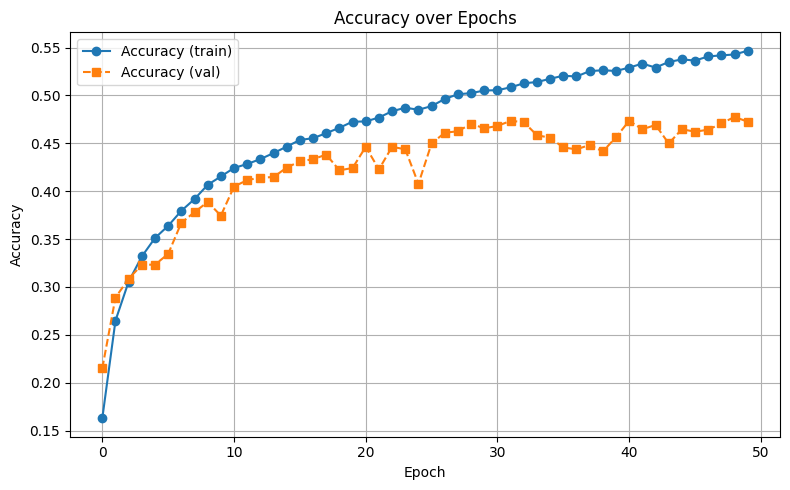

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_iou_20250516-204444_normalized_polynomial_trevesky.png


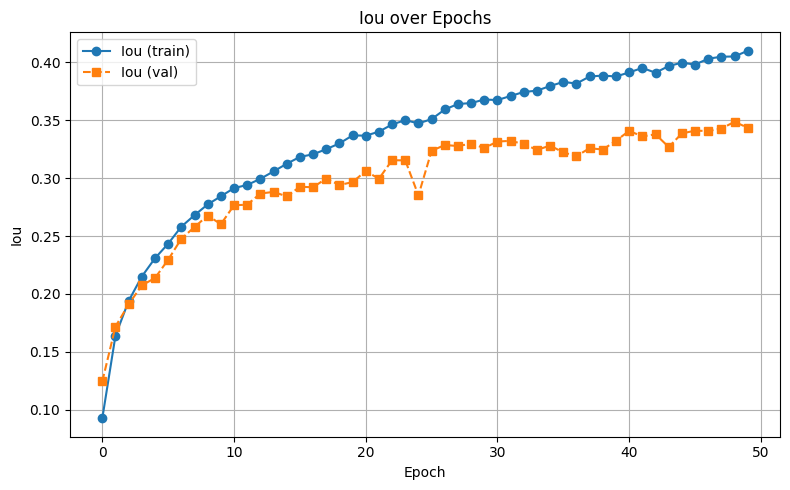

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_dice_20250516-204444_normalized_polynomial_trevesky.png


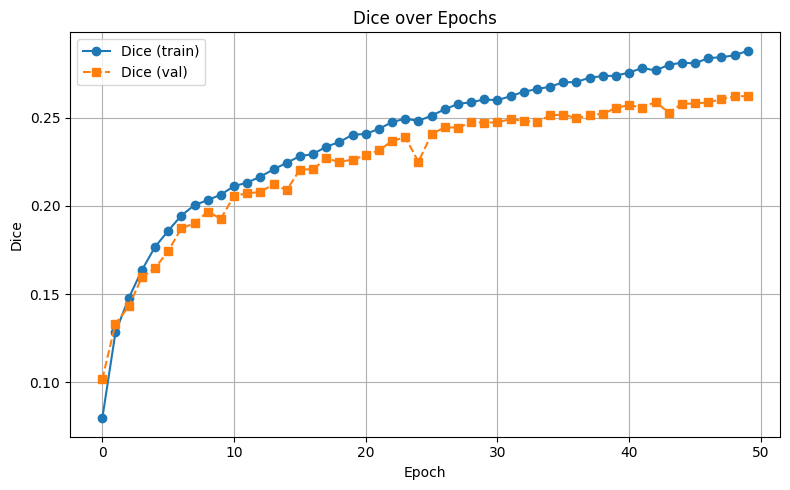

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/graphs/unet++_resnet34_None_32bs_50ep_lr1e-04_miou_20250516-204444_normalized_polynomial_trevesky.png


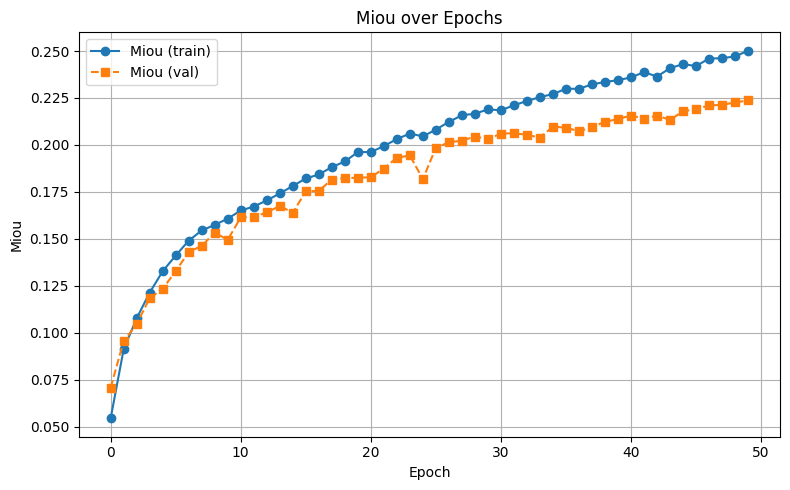

In [17]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_polynomial_trevesky.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [18]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_polynomial_trevesky.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/models/unet++_resnet34_None_32bs_50ep_lr1e-04_normalized_polynomial_trevesky.pth


In [19]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"unet++_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_polynomial_trevesky_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/UNET++/metrics/unet++_resnet34_None_32bs_50ep_lr1e-04_normalized_polynomial_trevesky_metrics.csv
